# How Does Ligo Point Back to a Source in the Sky?: Part 2

LIGO has been in the news again this fall, with the Nobel Prize being awarded to Weiss, Thorne, and Barish and now the discovery of a neutron star inspiral collision/merger. So, I'll revisit my previous notebook but now with all 3 interferometer sites.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline


## Setting up the problem

The first thing we want to do is figure out where on Earth the LIGO sites are.
There are LIGO interferometers in Hanford, WA and in Livingston, LA.

The Hanford site is at (46.45,-119.41) and the Livingston site is at (30.56,-90.77).

There is a European interferometer called Virgo that now provides a third site.
According to Wikipedia, it is located at (43.63,10.50).

So, we first need to convert these into more useful coordinates. Regular spherical 
coordinates would be most useful.

In [4]:
def to_spherical(lat,lon):
    
    return np.pi/180 * np.array([90-lat,(360+lon)%360])

# Hanford, WA 
hanford = to_spherical(46.45,-119.41)
# Livingston, LA 
livingston = to_spherical(30.56,-90.77)
# Near Pisa, Tuscany
virgo = to_spherical(43.64,10.50)

print('Hanford: ' +str(hanford))
print('Livingston: ' +str(livingston))
print('Virgo: ' +str(virgo))


Hanford: [ 0.76009089  4.19908765]
Livingston: [ 1.03742371  4.69894995]
Virgo: [ 0.80913464  0.18325957]


The spherical coordinates here are a system where $\theta = 0$ corresponds to the direction
of up at the north pole, $(\theta,\phi) = (90^\circ,0^\circ)$ points up at the equator
on the prime meridian, and $(\theta,\phi) = (90^\circ,90^\circ)$ points up at at
the point (lat,lon)=(0,90), in the Indian Ocean south of Bangladesh.

This is a local coordinate system that rotates along with Earth, so if we want to 
point back to a specific place in the sky, we need to transform to a non-rotating
frame.

Now that things are in spherical coordinates, we'll actually keep transforming to
cartesian coordinates for our calculations.

In [5]:
def to_cartesian(th,ph):
    return np.array([
        np.sin(th)*np.cos(ph),
        np.sin(th)*np.sin(ph),
        np.cos(th)
        ]) 

hf = to_cartesian(hanford[0],hanford[1])
ls = to_cartesian(livingston[0],livingston[1])
vg = to_cartesian(virgo[0],virgo[1])

print('Hanford: ' +str(hf))
print('Livingston: ' +str(ls))
print('Virgo: ' +str(vg))

Hanford: [-0.33833122 -0.60019623  0.72477339]
Livingston: [-0.01157197 -0.86101944  0.50844038]
Virgo: [ 0.71157198  0.13188207  0.69012494]


Now we can ask ourselves what the maximum time separation allowed for different combinations of detectors is. Given vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ for two sites, the distance between the sites is:

$ d =  R_\oplus |\mathbf{v}_1 - \mathbf{v}_2|$

where $R_\oplus$ is Earth's radius (assuming a spherical Earth). The maximal time separation between a gravitational wave signal traveling from one site to another is just $d/c$ and our vectors are unit vectors by construction, so we can write the time as:

$ \Delta t = \frac{R_\oplus}{c} \sqrt{2(1 - \mathbf{v}_1\cdot\mathbf{v}_2)}$


In [6]:
earthRadius = 6371e3 # m
speedOfLight = 3e8 # m/s

t_hl = earthRadius/speedOfLight * np.sqrt(2*(1-hf.dot(ls)))
t_hv = earthRadius/speedOfLight * np.sqrt(2*(1-hf.dot(vg)))
t_lv = earthRadius/speedOfLight * np.sqrt(2*(1-ls.dot(vg)))

print('Hanford/Livingston: %.2f msec'%(1e3*t_hl,))
print('Hanford/Virgo: %.2f msec'%(1e3*t_hv,))
print('Livingston/Virgo: %.2f msec'%(1e3*t_lv,))

Hanford/Livingston: 10.00 msec
Hanford/Virgo: 27.19 msec
Livingston/Virgo: 26.37 msec


So, we see that we get a maximum separation of 10 milliseconds between the two LIGO sites and 22-24 milliseconds
if we add Virgo.

## The Direction Likelihood

Now suppose we can measure the signal times at each site to some common uncertainty $\sigma$.
Then the uncertainty for the time separation $\Delta t = t_1 - t_2$ is just $\sigma\sqrt{2}$,
assuming no correlations between the time measurements. 

Now, the time is probably going to follow something like a Gaussian distribution, and if we 
combine multiple Gaussians, we just get another Gaussian, so the likelihood of measuring $\Delta t$ given some direction $(\theta,\phi)$ is:

$ L(\Delta t|\theta,\phi) = \frac{1}{\sqrt{8\pi \sigma^2}} \exp\left(-\frac{1}{8\sigma^2}(\Delta t - \frac{R_\oplus}{c}(\mathbf{v}_1 - \mathbf{v}_2)\cdot \mathbf{u}(\theta,\phi))^2\right)$

where $\mathbf{v}_i$ are the unit vectors of the two detectors and $\mathbf{u}(\theta,\phi)$ is the unit vector of the signal direction (opposite the source).

Using this, we can calculate the likelihood for LIGO (Hanford and Livingston) for a grid of $(\theta,\phi)$ points. In this case, we can treat the Livingston site as $t=0$, so the 3-site result is just:

$ L^{tot}(\Delta t_1,\Delta t_2|\theta,\phi) = L(\Delta t_1|\theta,\phi)L(\Delta t_2|\theta\phi) $

where $\Delta t_1$ is the time difference between Hanford and Livingston and $\Delta t_2$ is the time difference between Virgo and Hanford. 

In [53]:
def get_time_diffs(theta,phi):
    
    u = to_cartesian(theta,phi)
    hfCos = u.dot(hf)
    lCos = u.dot(ls)
    vCos = u.dot(vg)
    dx1 = earthRadius * (hfCos-lCos)
    dt1 = dx1 / speedOfLight
    dx2 = earthRadius * (vCos-lCos)
    dt2 = dx2 / speedOfLight
    return dt1,dt2

def Likelihood(time1,time2,uncertainty,theta,phi):
    dt1,dt2 = get_time_diffs(theta,phi)
    return np.exp(-0.5*( (dt1-time1)/uncertainty) **2) \
                            * np.exp(-0.5*( (dt2-time2)/uncertainty) ** 2)

def LikelihoodGrid(time1,time2,uncertainty):
    uncertainty = np.sqrt(2) * uncertainty

    npts = 200
    phi = np.linspace(-np.pi,np.pi,npts)
    theta = np.linspace(0,np.pi,npts)
    grid_theta,grid_phi = np.meshgrid(theta,phi)

    likelihood = np.zeros([npts,npts])

    for i in range(npts):
        for j in range(npts):
            likelihood[i,j] = Likelihood(time1,time2,uncertainty,grid_theta[i,j],grid_phi[i,j])

    return grid_theta,grid_phi,likelihood

## Plotting the Results

Now that we can calculate the likelihood, we can plot the results.

The Basemap toolkit for Matplotlib provides some nice tools for making plots on 2D projections such as 
skymaps. We will use a Hammer projection for our plots here. In our projections, the top
is the direction of up at the north pole, the center is the direction of up at the equator on the prime meridian,
and the far left and right are both the same point on the equator in the Indian Ocean south of Bangladesh.

In [54]:
def make_plot(time1,time2,uncertainty):
    th,ph,ll = LikelihoodGrid(time1,time2,uncertainty)
    #print(ll)
    f = plt.figure(1,figsize=(10,5))
    bmap = Basemap(projection='hammer',lon_0=0)
    bmap.drawmeridians(np.arange(0,360,60),color='0.5')
    bmap.drawparallels(np.arange(-90,90,30),color='0.5')
    lats = 90 - 180./np.pi * th
    lons = ph * 180./np.pi
    x,y = bmap(lons,lats)

    bmap.pcolor(x,y,ll,cmap='gist_heat',vmin=0,vmax=1)
    cb = bmap.colorbar(location='right')
    cb.set_label('Likelihood',size=18)
    plt.title(r'Hammer Projection, $(\Delta t_1,\Delta t_2)$ = (%.2e,%.2e) $\pm$ %0.2e s'%(time1,time2,uncertainty),size=14)

    cb.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
    cb.ax.tick_params(labelsize=16)
    plt.show()

Instead of just making guesses at the time differences as before, I will now calculate the typical time difference for a given position and then plot the likelihood. This ensures that we get more realistic results.

### From 0$^\circ$ N, 0$^\circ$ E with 1 ms Uncertainty

We'll start by putting the signal right at the center of the plot.

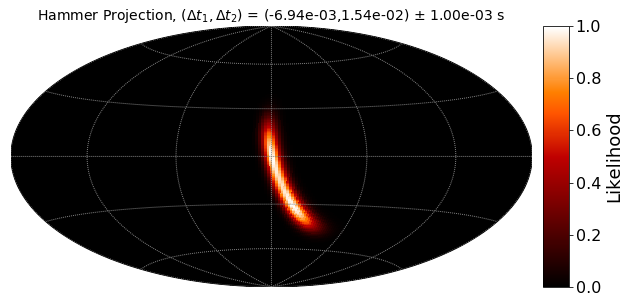

In [57]:
t1,t2 = get_time_diffs(90*np.pi/180,0*np.pi/180)
make_plot(t1,t2,0.001)

For this direction, we see the likelihood as an elongated blog. The blob is not symmetric about our initial direction. Instead, the likelihood extends south and east from the true position.

### North and East Direction

We'll now check the likelihood for a signal coming from 45$^\circ$ N, 45$^\circ$ E.

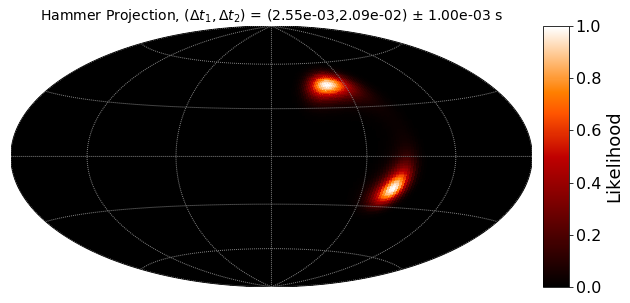

In [58]:
t1,t2 = get_time_diffs(45*np.pi/180,45*np.pi/180)
make_plot(t1,t2,0.001)

The likelihood has actually split into two independent lobes. Evidently, even with three detectors there is still some ambiguity.

### South and West Direction
What happens if we look at a position of (45$^\circ$ S, 45$^\circ$ W)

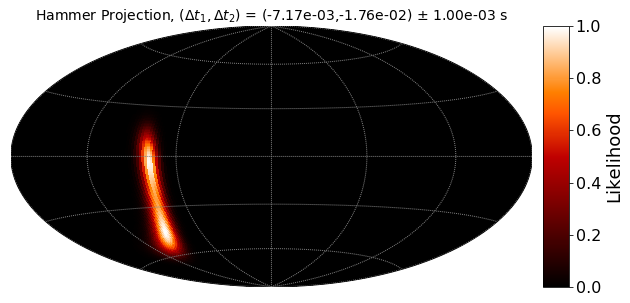

In [66]:
t1,t2 = get_time_diffs(135*np.pi/180,-90*np.pi/180)
make_plot(t1,t2,0.001)

In this direction of the sky, the likelihood still looks like an elongated peak, but we can start to see two independent lobes separating.

### Coming from nearly straight north

Now we'll set the direction to point from 75$^\circ$ N, 45$^\circ$ W.

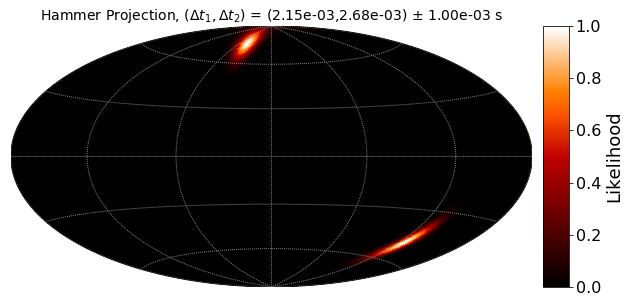

In [67]:
t1,t2 = get_time_diffs(15*np.pi/180,-45*np.pi/180)
make_plot(t1,t2,0.001)

We can see that the two lobe structure persists for various parameters.

# Increasing the Timing Uncertainty

What happens when the uncertainty increases to, say 3 ms and 10 ms?

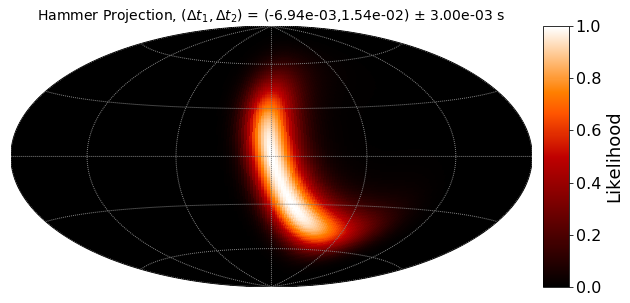

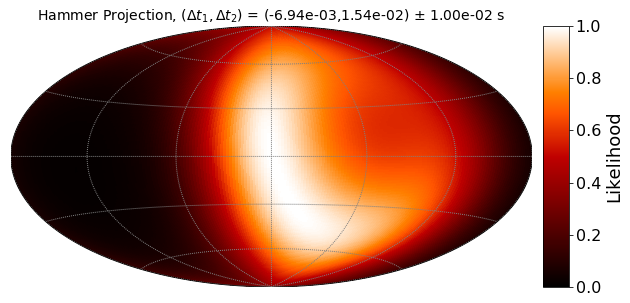

In [62]:
t1,t2 = get_time_diffs(90*np.pi/180,0*np.pi/180)
make_plot(t1,t2,0.003)
make_plot(t1,t2,0.01)


We see that we still get a nice elongated blob for 3 ms uncertainty but by 10, the blob starts govering a large fraction of the sky.

## Conclusions

We have seen that adding a third detector to LIGO does help break the degeneracy that lead to getting rings in the two-detector case. We instead get structures like elongated blobs or two compact blobs in our likelihood, allowing for much better pointing resolution.

But is there another way that LIGO could point back to a source? In fact, there likely is. Rather than looking at timing, if LIGO could try to look for the relative size of the signal. Gravitational waves cause quadrupole deformations in the plane perpendicular to the motion of the wave. The signal amplitude will be very dependent on the angle of the wave with respect to the detector. In fact, the joint LIGO/Virgo paper on the neutron star merger says that they used a "combination of the timing, phase, and amplitude of the source" to point back to a particular place in the sky (Phys. Rev. Lett. **119** 161101 (2017), https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.161101). The paper has a reference to an arXiv preprint (https://arxiv.org/abs/1612.01471) that talks about using this information to localize a source in **three** dimensions. In the full analysis, it is possible to not just point to a position in the sky but also to say how far away the object was.